In [1]:
import sys
import os
import numpy as np
import tensorflow as tf


py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

from src.close_policy import *
from src.utils import *
from src.metrics import *
from src.loss_function import *

2022-09-16 10:06:00.918337: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print(tf.config.list_physical_devices())
tf.device('GPU:1') 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# # choose your directory path  
project_sub_path = "relay_plot"
  
# Parent Directory path
parent_dir = ""
  
# Path
try : 

    path = os.path.join(parent_dir, project_sub_path)
    os.mkdir(path)
    print("Directory '% s' created" % project_sub_path)
except FileExistsError : 
    pass

Directory 'relay_plot' created


In [ ]:
def channel_gain_with_gaussian_fading_G(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

In [10]:
root_dir ='DNN'
tau=0.25

model = tf.keras.models.load_model(root_dir+'/lambda = 10_0.5/weights/10_0.5.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'opportunistic_rate':opportunistic_rate_DF(Lambda, tau, P_P), 'outage':outage_DF(Lambda, tau, P_P),'Delta': delta_DF(Lambda, tau, P_P), 'delta_out':delta_out_DF(Lambda, tau, P_P), 'V_Qos':quality_of_service_violation_DF(tau=0.25),"custom_sigmoid":custom_sigmoid})


In [14]:
n = 256
sampling = 10000
step_sampling = 100
P_P = 10
p_min = 0
p_max = 10
x_min, x_max = p_min, p_max
y_min, y_max = p_min, p_max

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_P = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_P = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_S = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_S = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_PP = np.linalg.norm(U_P - D_P, axis=1)
d_PS = np.linalg.norm(U_P - D_S, axis=1)
d_PR = np.linalg.norm(U_P - R  , axis=1)
d_SP = np.linalg.norm(U_S - D_P, axis=1)
d_SS = np.linalg.norm(U_S - D_S, axis=1)
d_SR = np.linalg.norm(U_S - R  , axis=1)
d_RP = np.linalg.norm(R   - D_P, axis=1)
d_RS = np.linalg.norm(R   - D_S, axis=1)

#d_11, d_12, d_1R, d_21, d_22, d_2R, , d_R2
D_test_R = np.c_[d_RP, d_PP, d_SR, d_PR, d_SS, d_RS, d_SP, d_PS].astype(np.float32)


P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)
D_mean = np.zeros(Rxx.shape)
S_mean = np.zeros(Rxx.shape)
pr_np = 'relay_plot/P_R_mean2'
ps_np = 'relay_plot/P_S_mean2'
alpha_np = 'relay_plot/alpha_mean2'
D_np = 'relay_plot/D_mean2'
S_np = 'relay_plot/S_mean2'

for i in range(int(sampling/step_sampling)):
    print(i)
    
    G = channel_gain_with_gaussian_fading_G((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), 7)
    Y = model.predict(G, batch_size = 4096)
    D = primary_rate_degradation(G[:,0], G[:,1], G[:,6], Y[:,0], Y[:,1], Y[:,2])
    S = secondary_rate(G[:,0], G[:,1], G[:,2], G[:,3], G[:,4], G[:,5], G[:,6], G[:,7], Y[:,0], Y[:,1], Y[:,2]) 
    #S = S[:,8]
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)

    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    D_mean = D_mean + np.sum(D.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    S_mean = S_mean + np.sum(S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)   

    np.savez(pr_np, P_R_mean)
    np.savez(ps_np, P_S_mean)
    np.savez(alpha_np, aplha_mean)
    np.savez(D_np, D_mean)
    np.savez(S_np, S_mean)


P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

0
1600/1600 [==============================] - 2s 1ms/step
1
1600/1600 [==============================] - 2s 1ms/step
2
1600/1600 [==============================] - 2s 1ms/step
3
1600/1600 [==============================] - 2s 1ms/step
4
1600/1600 [==============================] - 2s 1ms/step
5
1600/1600 [==============================] - 2s 1ms/step
6
1600/1600 [==============================] - 2s 1ms/step
7
1600/1600 [==============================] - 2s 1ms/step
8
1600/1600 [==============================] - 2s 1ms/step
9
1600/1600 [==============================] - 2s 1ms/step
10
1600/1600 [==============================] - 2s 1ms/step
11
1600/1600 [==============================] - 2s 1ms/step
12
1600/1600 [==============================] - 2s 1ms/step
13
1600/1600 [==============================] - 2s 1ms/step
14
1600/1600 [==============================] - 2s 1ms/step
15
1600/1600 [==============================] - 2s 1ms/step
16
1600/1600 [==============================] - 2s

In [16]:
p_min = 0
p_max = 10


P_R_mean = np.load('relay_plot/P_R_mean2.npz')
P_S_mean = np.load('relay_plot/P_S_mean2.npz')
aplha_mean = np.load('relay_plot/alpha_mean2.npz')
D_mean = np.load('relay_plot/D_mean2.npz')
S_mean = np.load('relay_plot/S_mean2.npz')

P_R_mean.files
P_R_mean = P_R_mean['arr_0']

P_S_mean.files
P_S_mean = P_S_mean['arr_0']

aplha_mean.files
aplha_mean = aplha_mean['arr_0']

D_mean.files
D_mean = D_mean['arr_0']
S_mean.files
S_mean = S_mean['arr_0']

n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_P = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_P = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_S = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10

D_S = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

In [17]:
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

### Average predicted relay power

/tmp/ipykernel_836645/811439405.py:11: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')


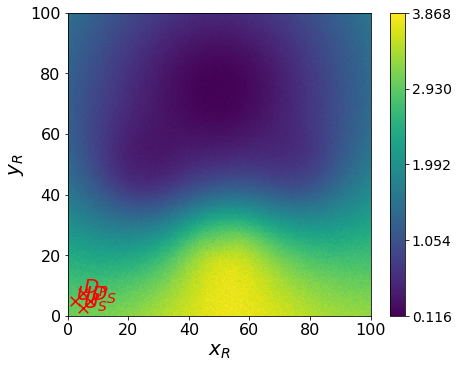

In [18]:
pos_min = p_min*10
pos_max = p_max*10

plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()
D_mean = D_mean*100

cax = ax.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_P[0,:], "$U_P$"), (U_S[0,:], "$U_S$"), (D_P[0,:], "$D_P$"), (D_S[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 


plt.savefig('P_R.pdf', dpi=300, bbox_inches='tight')

### Average primary rate degradation

In [32]:
np.nanmin(D_mean)

18.536912805457984

/tmp/ipykernel_836645/4125877149.py:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cax, ticks=np.linspace(np.nanmin(D_mean),np.nanmax(D_mean),5), shrink=1, cmap = 'viridis')


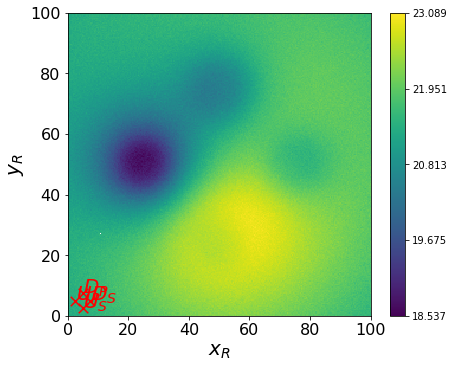

In [33]:
pos_min = p_min*10
pos_max = p_max*10
plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()

#D_mean = D_mean*100
cax = ax.matshow(D_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cax, ticks=np.linspace(np.nanmin(D_mean),np.nanmax(D_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_P[0,:], "$U_P$"), (U_S[0,:], "$U_S$"), (D_P[0,:], "$D_P$"), (D_S[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('D_Mean.pdf', dpi=300, bbox_inches='tight')

### Average secondary rate

/tmp/ipykernel_836645/1401867674.py:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')


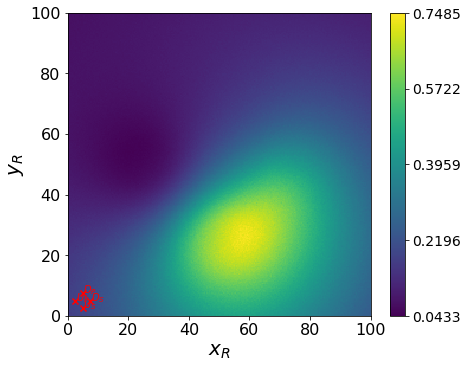

In [20]:
pos_min = p_min*10
pos_max = p_max*10
#sns.set(font_scale=5) 
plt.figure(figsize=(6,4.8))

ax = plt.gca()
plt.tight_layout()
cax = ax.matshow(S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_P[0,:], "$U_P$"), (U_S[0,:], "$U_S$"), (D_P[0,:], "$D_P$"), (D_S[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
        
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('S_Mean.pdf', dpi=300, bbox_inches='tight')